In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to import images
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
%matplotlib inline

/Library/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


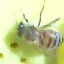

In [2]:
directory = "bee_imgs/"
#64x64 for faster training.
#example of loading 1 picture
picture3 = image.load_img(directory+"041_073.png", target_size=(64,64))
picture3

In [3]:
picture3_ = image.img_to_array(picture3)

In [4]:
picture3_.shape #3 channels, for 3 colors

(64, 64, 3)

In [5]:
df = pd.read_csv("bee_data.csv")

In [6]:
df.shape

(5172, 9)

In [7]:
df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [8]:
#create a list to hold the 4d image tensors data
X_pics = [image.load_img(directory+img_name,target_size=(64,64)) for img_name in df["file"]]

#a list of np tensors
X = [np.array(image.img_to_array(i)) for i in X_pics]

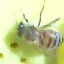

In [9]:
#verified to be in order. Should be identical to the picture above
X_pics[2] #third picture

In [10]:
print(np.amax(X))
print(np.amin(X))

#rescale for training, using minmax scaling
X = [i/255.0 for i in X]
print(np.amax(X))
print(np.amin(X))

255.0
0.0
1.0
0.0


In [11]:
print(df.health.value_counts())
target_ids = []
for i in df.health:
    if i not in target_ids:
        target_ids.append(i)

healthy                       3384
few varrao, hive beetles       579
Varroa, Small Hive Beetles     472
ant problems                   457
hive being robbed              251
missing queen                   29
Name: health, dtype: int64


In [12]:
#recall, cnn only depends on 2 things, the target and the images themselves!
#doing a label assignment

y_keys = {"healthy":np.array([1,0,0,0,0,0]),
         "few varrao, hive beetles":np.array([0,1,0,0,0,0]),
         "Varroa, Small Hive Beetles":np.array([0,0,1,0,0,0]),
         "ant problems":np.array([0,0,0,1,0,0]),
         "hive being robbed":np.array([0,0,0,0,1,0]),
         "missing queen":np.array([0,0,0,0,0,1])}
y = [y_keys[i] for i in df.health]

In [13]:
#example of turning images into array with Keras
picture3 = image.img_to_array(picture3)
print(np.sum(X[2] == picture3/255)) #all true
print(64*64*3)

12288
12288


In [14]:
#input as 1 type of target only, return some random indices for image showing
def random_imgs(df,num_images,X_pics):
    index_lst = df["file"].sample(n=num_images).index
    image_lst = []
    for i in index_lst:
        image_lst.append(X_pics[i])
    return image_lst

In [15]:
healthy = random_imgs(df[df["health"]=="healthy"],4,X_pics)
hive_beetles = random_imgs(df[df["health"] == "few varrao, hive beetles"],4,X_pics)
ant_probs = random_imgs(df[df["health"] == "ant problems"],4,X_pics)
hive_robbed = random_imgs(df[df["health"] == "hive being robbed"],4,X_pics)
varroa = random_imgs(df[df["health"] == "Varroa, Small Hive Beetles"],4,X_pics)

In [16]:
#only plot 2x2 images. Helper function. One can always generalize the function if neccessary
def plot_bees(img_lst,title):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8,8))
    ax[0].imshow(img_lst[0])
    ax[0].set_title(title) #we only use 1 because long healthy column values are too long and overlapping the tittle
    ax[1].imshow(img_lst[1])
    #ax[1].set_title(title)
    ax[2].imshow(img_lst[2])
    #ax[2].set_title(title)
    ax[3].imshow(img_lst[3])
    #ax[3].set_title(title)
    
    plt.show()
    
#plot_bees(healthy,"healthy")

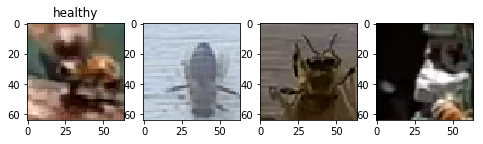

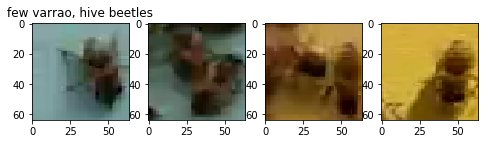

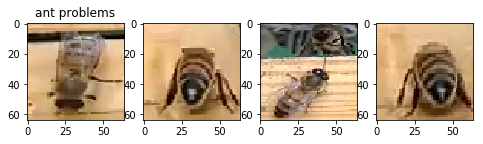

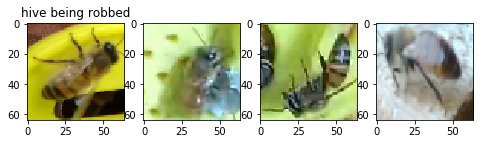

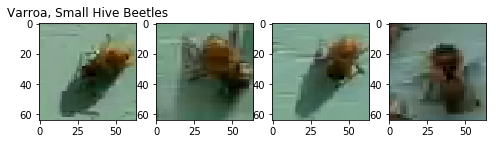

In [17]:
plot_bees(healthy,"healthy")
plot_bees(hive_beetles,"few varrao, hive beetles")
plot_bees(ant_probs,"ant problems")
plot_bees(hive_robbed,"hive being robbed")
plot_bees(varroa,"Varroa, Small Hive Beetles")

In [18]:
print(df.health.value_counts(normalize=True))
print(df.health.value_counts())

healthy                       0.654292
few varrao, hive beetles      0.111949
Varroa, Small Hive Beetles    0.091261
ant problems                  0.088360
hive being robbed             0.048531
missing queen                 0.005607
Name: health, dtype: float64
healthy                       3384
few varrao, hive beetles       579
Varroa, Small Hive Beetles     472
ant problems                   457
hive being robbed              251
missing queen                   29
Name: health, dtype: int64


# Keras CNN

In [19]:
#we'll be using keras for prototyping first
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks


from sklearn.model_selection import train_test_split
history = callbacks.History() #need to be defined first

In [20]:

def train_cnn():
    #to combat overfitting, better optimization for CNN, we'll be using Batch normalization PRIOR to activation.
    #There has been a debate on where to use it, but the consensus has been to use it prior/after non-linearity (activation)
    model = Sequential()

    #3x3 matrix with 11 feature maps in total, conventional. 3d array for colored img, RGB. 255 in term of intensity max/min
    model.add(Convolution2D(11,3,3, input_shape=(64,64,3))) #tensorflow backend tuples = (128,128,3). Use relu to eliminate the neg values 
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),padding="SAME")) #took out strides=1 for speed (no overlapping! remember the paper)
    

    model.add(Convolution2D(21,3,3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),padding="SAME"))

    #third convo layer with more feature filter size, 41 for better detection.
    model.add(Convolution2D(41,3,3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),padding="SAME"))

    #Flattening to input the ann
    model.add(Flatten()) #no argument needed

    #Ann section with flattened stuff as input. Notice we don't need the input size like low level tensorflow here
    #hidden layer, 200
    model.add(Dense(200, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation="softmax"))
    
    #https://cwiki.apache.org/confluence/display/MXNET/Multi-hot+Sparse+Categorical+Cross-entropy
    #we use categorical cross entropy for our sparse matrix target.
    #smaller learning rate to optimize better. Default has periodic dips
    model.compile(optimizer=optimizers.rmsprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])

    return model


In [21]:
#splitting into train,test, val datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,stratify=y_train, random_state=1)

In [22]:
#note that this val method was used differently than the rest
#uncomment for training
'''
model1 = train_cnn()
history1 = model1.fit(np.array(X_train),np.array(y_train),validation_data=(np.array(X_val),np.array(y_val)),
                      verbose=True,shuffle=True,epochs=50)
'''

/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(11, (3, 3), input_shape=(64, 64, 3...)`
  
/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(21, (3, 3), activation="relu")`
  
/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(41, (3, 3), activation="relu")`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 3309 samples, validate on 828 samples
Epoch 1/50
3309/3309 [==============================] - 24s - loss: 0.8155 - acc: 0.7401 - val_loss: 1.7546 - val_acc: 0.6546
Epoch 2/50
3309/3309 [==============================] - 20s - loss: 0.4263 - acc: 0.8480 - val_loss: 1.6407 - val_acc: 0.6546
Epoch 3/50
3309/3309 [==============================] - 21s - loss: 0.2811 - acc: 0.8957 - val_loss: 1.2153 - val_acc: 0.6703
Epoch 4/50
3309/3309 [==============================] - 22s - loss: 0.2236 - acc: 0.9081 - val_loss: 0.6437 - val_acc: 0.8128
Epoch 5/50
3309/3309 [==============================] - 24s - loss: 0.1827 - acc: 0.9308 - val_loss: 0.3598 - val_acc: 0.8696
Epoch 6/50
3309/3309 [==============================] - 20s - loss: 0.1563 - acc: 0.9420 - val_loss: 0.2

In [23]:
def model_plot(history,epochs,title,y_range=[0.5,1.0],save=0 ):
    train_losses = history.history["loss"]
    val_losses = history.history["val_loss"]
    plt.plot([i for i in range(0,epochs)],train_losses,val_losses)
    plt.legend(["Train Loss","Val Loss"])
    plt.title(title)
    
    if save == 1:
        plt.savefig(title+"_Losses.jpg",dpi=1000)
    plt.show()
    
    
    train_losses = history.history["acc"]
    val_losses = history.history["val_acc"]
    plt.plot([i for i in range(0,epochs)],train_losses,val_losses)
    plt.legend(["Train_acc","Val_acc"])
    plt.title(title)
    plt.ylim(y_range)
    
    if save == 1:
        plt.savefig(title+"_Accuracy.jpg",dpi=1000)
    plt.show()

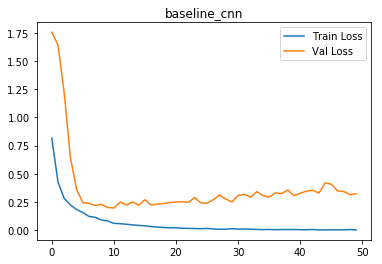

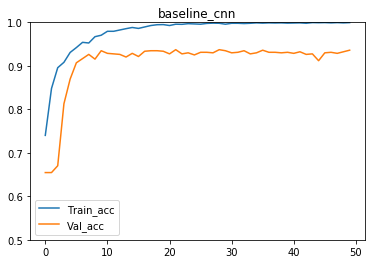

In [24]:
#uncomment for plotting
model_plot(history1,epochs=50,title="baseline_cnn")

Overall, the model isn't terrible, but our accuracy is very high compared to vanilla ~85% prior to multiple changes such as filters, batch norm, dropout, dense 500 layers, and using Adam optimizer

What we have learned on our model ? After playing around with a lot of filter sizes and dropouts/batch normalization (with the general rules of starting out with small # of filters, and increase them as we make the output of each conv layers smaller, as each filter is now more responsible for more detailed inspection the further down we go), we have a somewhat accurate prediction with a slight overfitting problem. The data begins to overfit around epoch #10. 

Also, it's worth to note that there's an optimization problem(spikes on test sets, perhaps with limited dataset - these images aren't a lot to work it, especially on the minority targets. The fix for this was to reduce the learning rate from 0.001 to 0.0001 and increased the epochs). 

Let's improve on the current condition with 2 options: generating extra images on our data set, and/or upsampling our dataset. Due to the limited computing resources, we will be sticking with the pre-existing architecture for our CNN.

# Oversampling and Generating Data

In [25]:
def datasets_split(X,y):
    print("original \n",pd.Series(y).value_counts(normalize=True))
    #split out test set and train set. To make things easier, let's make the y into a pandas Series for stratifying
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=1)
    #now from the train set, we split out the train set and the validation set. Remember, we can't validate with
    #newly generated data. it won't do our model any good!
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,stratify=y_train, random_state=1)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

#example of stratified result
X_train, X_test, X_val, y_train, y_test, y_val = datasets_split(X,y)
print(pd.Series(y_val).value_counts(normalize=True))
#X_val

original 
 [1, 0, 0, 0, 0, 0]    0.654292
[0, 1, 0, 0, 0, 0]    0.111949
[0, 0, 1, 0, 0, 0]    0.091261
[0, 0, 0, 1, 0, 0]    0.088360
[0, 0, 0, 0, 1, 0]    0.048531
[0, 0, 0, 0, 0, 1]    0.005607
dtype: float64
[1, 0, 0, 0, 0, 0]    0.654589
[0, 1, 0, 0, 0, 0]    0.112319
[0, 0, 1, 0, 0, 0]    0.090580
[0, 0, 0, 1, 0, 0]    0.088164
[0, 0, 0, 0, 1, 0]    0.048309
[0, 0, 0, 0, 0, 1]    0.006039
dtype: float64


In [26]:
#Data Augmentation. Generating additional data for testing
#refer to Keras for extra documentation as well as
#https://machinelearningmastery.com/image-augmentation-deep-learning-keras/ for a brief introduction
def data_aug(X_train):
    datagen = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, #for randomizing, not 2 same images in the 2 different batches
        vertical_flip=True,   #for randomizing, not 2 same images in the 2 different batches
        width_shift_range=0.3,
        height_shift_range=0.3)
    
    datagen.fit(X_train)
    # fits the model on batches with real-time data augmentation:
    return datagen

datagen = data_aug(X_train)

In [27]:
#uncomment for training
'''
model2 = train_cnn()
history2 = model2.fit_generator(datagen.flow(np.array(X_train),np.array(y_train),batch_size=50),
                              validation_data= (np.array(X_val),np.array(y_val)),
                              steps_per_epoch=len(X_train) / 50,epochs=50)
'''

/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(11, (3, 3), input_shape=(64, 64, 3...)`
  
/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(21, (3, 3), activation="relu")`
  
/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(41, (3, 3), activation="relu")`


Epoch 1/50
67/66 [==============================] - 21s - loss: 1.1354 - acc: 0.6525 - val_loss: 1.7653 - val_acc: 0.6473
Epoch 2/50
67/66 [==============================] - 20s - loss: 0.7703 - acc: 0.7356 - val_loss: 1.7573 - val_acc: 0.6316
Epoch 3/50
67/66 [==============================] - 20s - loss: 0.6569 - acc: 0.7749 - val_loss: 1.6858 - val_acc: 0.6425
Epoch 4/50
67/66 [==============================] - 20s - loss: 0.5648 - acc: 0.7962 - val_loss: 1.4531 - val_acc: 0.6401
Epoch 5/50
67/66 [==============================] - 20s - loss: 0.5246 - acc: 0.8094 - val_loss: 1.1162 - val_acc: 0.6836
Epoch 6/50
67/66 [==============================] - 25s - loss: 0.4752 - acc: 0.8236 - val_loss: 0.8928 - val_acc: 0.7089
Epoch 7/50
67/66 [==============================] - 23s - loss: 0.4230 - acc: 0.8480 - val_loss: 0.5997 - val_acc: 0.7899
Epoch 8/50
67/66 [==============================] - 22s - loss: 0.4239 - acc: 0.8358 - val_loss: 0.4864 - val_acc: 0.8273
Epoch 9/50
67/66 [======

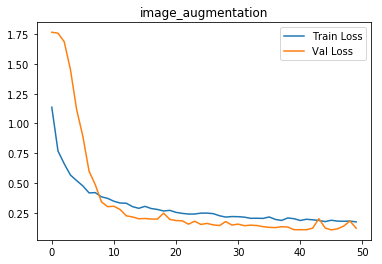

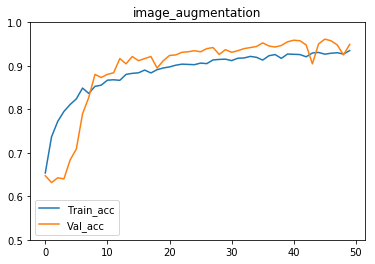

In [28]:
#uncomment for plotting after training
model_plot(history2,epochs=50,title="image_augmentation")

As expected, image augmentation is a technique widely used for small datasets in cnn, as well as forcing our cnn to learn "better" with the small variation changes. The overfitting problem is also mostly gone

In [29]:
df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [30]:
#we'll upsample until our each of our target has as many datapoints as the highest target value (healthy)
#X_pics were defined from the very beginning to contain all our images, and y contains all the targets.
def max_oversampling(df,X_pics,y):
    
    #we need to resplit the original dataset in a form of dataframe.
    #this is a total df with additional pixels and target columns
    
    df["pixels"] = [np.array(image.img_to_array(i)) for i in X_pics]
    df["pixels"] = df["pixels"]/255.0 #we re-imported, so have to rescale (otherwise the cnn won't learn)
    df["target"] = y
    
    #so we'll input the whole df, with pixels and target to help create a true"oversample" split solely with
    #the training data, not contaminating the val or test. We'll ignore the test/val sets
    #the df itself (X_train), should contain both the target and pixels.
    #we only use df_train (including both target and features as added in the above lines)
    df_train, temp1, temp2, temp3, temp4, temp5 = datasets_split(df,y)
    max_size = df_train["health"].value_counts().max()
    lst = [df_train]
    for classification, group in df_train.groupby('health'):
        lst.append(group.sample(max_size-len(group), replace=True))
    df_new = pd.concat(lst)
    return df_new

In [31]:
#normally re-split again for no reason, then just to keep the reference the same prior to any partition.
X_train, X_test, X_val, y_train, y_test, y_val = datasets_split(X,y)

original 
 [1, 0, 0, 0, 0, 0]    0.654292
[0, 1, 0, 0, 0, 0]    0.111949
[0, 0, 1, 0, 0, 0]    0.091261
[0, 0, 0, 1, 0, 0]    0.088360
[0, 0, 0, 0, 1, 0]    0.048531
[0, 0, 0, 0, 0, 1]    0.005607
dtype: float64


In [32]:
#df_new is the new training set only, NOT val or test set
df_new = max_oversampling(df,X_pics,y)

original 
 [1, 0, 0, 0, 0, 0]    0.654292
[0, 1, 0, 0, 0, 0]    0.111949
[0, 0, 1, 0, 0, 0]    0.091261
[0, 0, 0, 1, 0, 0]    0.088360
[0, 0, 0, 0, 1, 0]    0.048531
[0, 0, 0, 0, 0, 1]    0.005607
dtype: float64


In [33]:
#quite important to shuffle our training set, since our function to upsample only concat the pd's togehter at the end
#for each categories. Thus, there is no randomization in our current df based on labels/target
df_new = shuffle(df_new)
print(df_new.health.value_counts())
df_new.head()

few varrao, hive beetles      2165
missing queen                 2165
ant problems                  2165
Varroa, Small Hive Beetles    2165
healthy                       2165
hive being robbed             2165
Name: health, dtype: int64


,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,pixels,target
2388,031_118.png,8/21/18,15:56,"Athens, GA, USA",30607,Italian honey bee,"few varrao, hive beetles",False,worker,"[[[0.4745098, 0.5647059, 0.5294118], [0.474509...","[0, 1, 0, 0, 0, 0]"
1609,040_439.png,8/21/18,15:56,"Athens, GA, USA",30607,Italian honey bee,"few varrao, hive beetles",False,worker,"[[[0.4862745, 0.6117647, 0.53333336], [0.48627...","[0, 1, 0, 0, 0, 0]"
3154,034_046.png,8/21/18,13:49,"Alvin, TX, USA",77511,VSH Italian honey bee,missing queen,False,worker,"[[[0.96862745, 0.98039216, 0.5137255], [0.9803...","[0, 0, 0, 0, 0, 1]"
3486,015_835.png,8/6/18,13:19,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker,"[[[0.5019608, 0.43137255, 0.34901962], [0.5019...","[1, 0, 0, 0, 0, 0]"
2991,039_005.png,8/28/18,10:53,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.4509804, 0.4, 0.050980393], [0.30588236, ...","[0, 0, 0, 0, 1, 0]"


In [34]:
#now we need to extract the right y's from the new training dataframe using the previously defined keys (y_keys dict)
X_upsampled = df_new.pixels.tolist()
y_upsampled = [y_keys[i] for i in df_new["health"]]

In [35]:
print(np.array(y_upsampled).shape)
print(np.array(X_upsampled).shape)
print(np.array(y_val).shape)
print(np.array(X_val).shape)
print(np.array(y_test).shape)
print(np.array(X_test).shape)

(12990, 6)
(12990, 64, 64, 3)
(828, 6)
(828, 64, 64, 3)
(1035, 6)
(1035, 64, 64, 3)


In [36]:
#uncomment for training
'''
model3 = train_cnn()
history3 = model3.fit(np.array(X_upsampled),np.array(y_upsampled),validation_data=(np.array(X_val),np.array(y_val)),
                      verbose=True,shuffle=True,epochs=50)
'''

/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(11, (3, 3), input_shape=(64, 64, 3...)`
  
/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(21, (3, 3), activation="relu")`
  
/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(41, (3, 3), activation="relu")`


Train on 12990 samples, validate on 828 samples
Epoch 1/50
12990/12990 [==============================] - 74s - loss: 0.5056 - acc: 0.8104 - val_loss: 0.8586 - val_acc: 0.7210
Epoch 2/50
12990/12990 [==============================] - 73s - loss: 0.1413 - acc: 0.9527 - val_loss: 0.2422 - val_acc: 0.9082
Epoch 3/50
12990/12990 [==============================] - 79s - loss: 0.0673 - acc: 0.9791 - val_loss: 0.3182 - val_acc: 0.8865
Epoch 4/50
12990/12990 [==============================] - 76s - loss: 0.0322 - acc: 0.9917 - val_loss: 0.2382 - val_acc: 0.9251
Epoch 5/50
12990/12990 [==============================] - 71s - loss: 0.0184 - acc: 0.9949 - val_loss: 0.2607 - val_acc: 0.9203
Epoch 6/50
12990/12990 [==============================] - 71s - loss: 0.0113 - acc: 0.9973 - val_loss: 0.3691 - val_acc: 0.9058
Epoch 7/50
12990/12990 [==============================] - 71s - loss: 0.0078 - acc: 0.9983 - val_loss: 0.3191 - val_acc: 0.9324
Epoch 8/50
12990/12990 [==============================] 

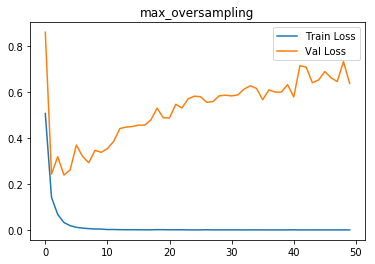

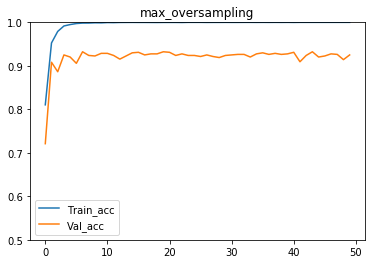

In [37]:
#uncomment for plotting
model_plot(history3,epochs=50,title="max_oversampling")

It is well-known that we are exposed to overfitting with max upsampling. Copying sub 30 images of a "missing queen" category up to 2000+ data point won't help our model. It will overfit as it has only seen so many "queen" types images. The problem of high computation and overfitting has been associated with oversampling.

All in all, the validation loss has stopped after the 5th epochs or so. Meaning our network isn't really learning anything new unfortunately. At that point, we also see a big divergence on our overfitting problem.

Case in point, don't use oversampling like this in a cnn

In [38]:
print(df_new.health.value_counts())
print(df.health.value_counts()) 
#the whole dataset only has 40 missing queens data. So less than 80% of that will be in training set.
#oversampling these data to 2000+ points won't help it learn from the 30 data points. The same can be applied to other
#labels/targets

few varrao, hive beetles      2165
missing queen                 2165
ant problems                  2165
Varroa, Small Hive Beetles    2165
healthy                       2165
hive being robbed             2165
Name: health, dtype: int64
healthy                       3384
few varrao, hive beetles       579
Varroa, Small Hive Beetles     472
ant problems                   457
hive being robbed              251
missing queen                   29
Name: health, dtype: int64


In [39]:
#our data is well splitted out from the pd Series based off index
print(df.health.value_counts().index.tolist())
print(df.health.value_counts().values)

['healthy', 'few varrao, hive beetles', 'Varroa, Small Hive Beetles', 'ant problems', 'hive being robbed', 'missing queen']
[3384  579  472  457  251   29]


Instead of using max oversampling, let's engineer the dataset to use a proportional oversampling. We'll be putting a higher weights on the lesser classes, but not overemphasize them to the point of being on "balanced" with the majority. Instead, we'll give them proportionally to the amount of data they have.

In [40]:
#let's create a proportional upsampling, where we don't upsampe the "healthy" label, and for every other label, we would
#upsample them by at most 4x, with the majority label having no multiplier.

#proportional_dict will contain the label (key), and mulplier of upsampling
#after playing around with the ratio, this is one of the more optimal result we've got
multiplier_dict = {"healthy":1,
         "few varrao, hive beetles":2, 
         "Varroa, Small Hive Beetles":2,
         "ant problems":2,
         "hive being robbed":3,
         "missing queen":4}
def proportional_oversampling(df,X_pics,y,multiplier_dict):
    
    #we need to resplit the original dataset in a form of dataframe.
    #this is a total df with additional pixels and target columns
    
    df["pixels"] = [np.array(image.img_to_array(i)) for i in X_pics]
    df["pixels"] = df["pixels"]/255.0 #normalize due to fresh import of dataframe
    df["target"] = y
    #again, we only care about the training oversampling, the val and the test should still be the same!
    df_train, temp1, temp2, temp3, temp4, temp5 = datasets_split(df,y)
    
    label_ids = df_train.health.value_counts().index.tolist() #list
    label_size = df_train.health.value_counts().values #list
    print("initial train set:\n",df_train.health.value_counts())
    result = [] #a list to hold all the sampled df's
    for i in range(len(label_ids)):
        #this function will 1: filter our the label/target of each "health" column,
        #multiply the number of sample size by the multiplier factor in the dictionary by randomly sampling with replacement
        #and finally append to the list for concat back to a single training dataframe.
        df_sampled = df_train[df_train["health"] == label_ids[i]].sample(n=(multiplier_dict[label_ids[i]]*label_size[i]),
        replace=True,random_state=101)
        result.append(df_sampled)
    df_new = pd.concat(result)
    #Shuffle so our data will come out in batches representing a generalized siutation. Otherwise, there will only
    #be 1 label for each batch.
    df_new = shuffle(df_new,random_state=202)
    return df_new

In [41]:
#since the last df_new was useless, we'll be re-using this variable name to establish our new baseline
df_new = proportional_oversampling(df,X_pics,y,multiplier_dict)

original 
 [1, 0, 0, 0, 0, 0]    0.654292
[0, 1, 0, 0, 0, 0]    0.111949
[0, 0, 1, 0, 0, 0]    0.091261
[0, 0, 0, 1, 0, 0]    0.088360
[0, 0, 0, 0, 1, 0]    0.048531
[0, 0, 0, 0, 0, 1]    0.005607
dtype: float64
initial train set:
 healthy                       2165
few varrao, hive beetles       370
Varroa, Small Hive Beetles     302
ant problems                   293
hive being robbed              161
missing queen                   18
Name: health, dtype: int64


In [42]:
df_new.health.value_counts()

healthy                       2165
few varrao, hive beetles       740
Varroa, Small Hive Beetles     604
ant problems                   586
hive being robbed              483
missing queen                   72
Name: health, dtype: int64

In [43]:
#example of stratified result
X_train, X_test, X_val, y_train, y_test, y_val = datasets_split(X,y)

original 
 [1, 0, 0, 0, 0, 0]    0.654292
[0, 1, 0, 0, 0, 0]    0.111949
[0, 0, 1, 0, 0, 0]    0.091261
[0, 0, 0, 1, 0, 0]    0.088360
[0, 0, 0, 0, 1, 0]    0.048531
[0, 0, 0, 0, 0, 1]    0.005607
dtype: float64


In [44]:
#okay, vous etes pret?!
#try to have upsampled2 the same as X_train to see if we can replicate the original content
X_upsampled2 = df_new.pixels.tolist()
y_upsampled2 = [y_keys[i] for i in df_new["health"]]
datagen = data_aug(X_upsampled2)

#uncomment for training
'''
model4 = train_cnn()
history4 = model4.fit_generator(datagen.flow(np.array(X_upsampled2),np.array(y_upsampled2),batch_size=50),
                              validation_data=(np.array(X_val),np.array(y_val)),
                              steps_per_epoch=len(X_train)/50,epochs=50)
'''

/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(11, (3, 3), input_shape=(64, 64, 3...)`
  
/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(21, (3, 3), activation="relu")`
  
/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(41, (3, 3), activation="relu")`


Epoch 1/50
67/66 [==============================] - 20s - loss: 1.3804 - acc: 0.5239 - val_loss: 1.7782 - val_acc: 0.6546
Epoch 2/50
67/66 [==============================] - 19s - loss: 0.8510 - acc: 0.6794 - val_loss: 1.7716 - val_acc: 0.6522
Epoch 3/50
67/66 [==============================] - 19s - loss: 0.6660 - acc: 0.7284 - val_loss: 1.7190 - val_acc: 0.6377
Epoch 4/50
67/66 [==============================] - 19s - loss: 0.5861 - acc: 0.7522 - val_loss: 1.4822 - val_acc: 0.6630
Epoch 5/50
67/66 [==============================] - 19s - loss: 0.5231 - acc: 0.7758 - val_loss: 1.0768 - val_acc: 0.7210
Epoch 6/50
67/66 [==============================] - 19s - loss: 0.4744 - acc: 0.7958 - val_loss: 0.6678 - val_acc: 0.7705
Epoch 7/50
67/66 [==============================] - 19s - loss: 0.4910 - acc: 0.7839 - val_loss: 0.4281 - val_acc: 0.8309
Epoch 8/50
67/66 [==============================] - 19s - loss: 0.4261 - acc: 0.8155 - val_loss: 0.3344 - val_acc: 0.8671
Epoch 9/50
67/66 [======

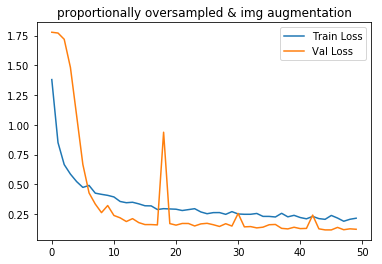

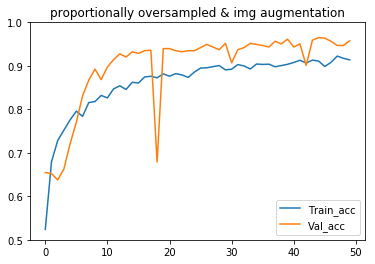

In [45]:
#uncomment for plotting
model_plot(history4,epochs=50,title="proportionally oversampled & img augmentation")

There are still some generalization gaps, but overall we have had some improvements over the previous model (max oversampling) in term of overfitting. Let's save all these graphs and weights prior to proceeding further. However, we possibly can improve this even further with various ratios. We still do not know if that really provide any meaningful info against the model with image augmentation.

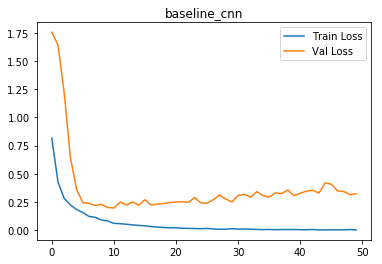

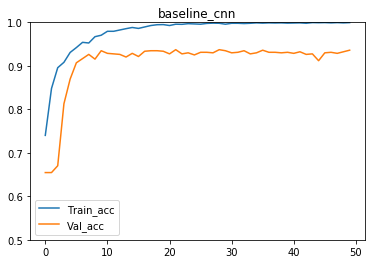

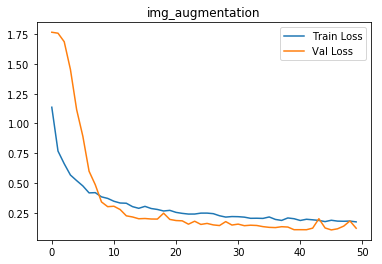

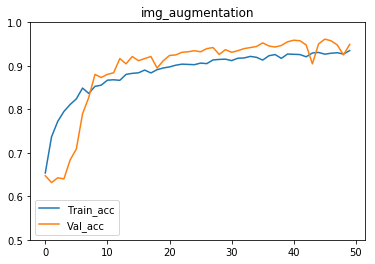

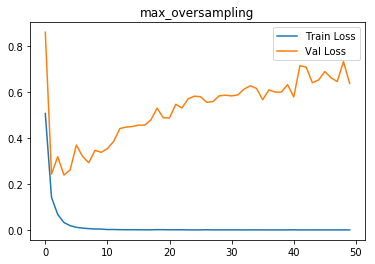

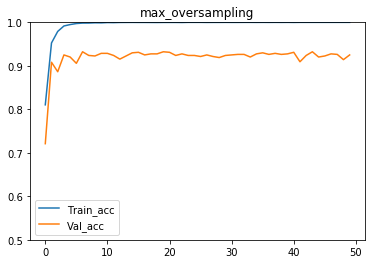

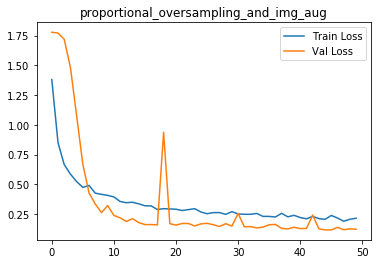

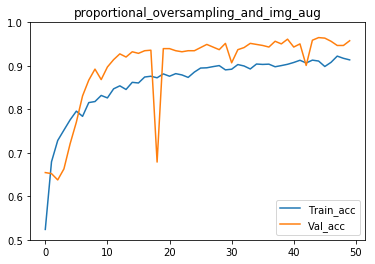

In [46]:
model_plot(history1,epochs=50,title="baseline_cnn",y_range=[0.5,1],save=1)
model_plot(history2,epochs=50,title="img_augmentation",y_range=[0.5,1],save=1)
model_plot(history3,epochs=50,title="max_oversampling",y_range=[0.5,1],save=1)
model_plot(history4,epochs=50,title="proportional_oversampling_and_img_aug",y_range=[0.5,1],save=1)

In [47]:
#to save all the weights for the future

model1.save_weights("model1.h5",overwrite=False)
model2.save_weights("model2.h5",overwrite=False)
model3.save_weights("model3.h5",overwrite=False)
model4.save_weights("model4.h5",overwrite=False)


[WARNING] model1.h5 already exists - overwrite? [y/n]u
Enter "y" (overwrite) or "n" (cancel).y
[TIP] Next time specify overwrite=True!
[WARNING] model2.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!
[WARNING] model3.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!
[WARNING] model4.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!


In [48]:
#to load the saved weights, remember to run all the cnn_defined stuff
'''
model1 = train_cnn()
model2 = train_cnn()
model3 = train_cnn()
model4 = train_cnn()

model1.load_weights("model1.h5")
model2.load_weights("model2.h5")
model3.load_weights("model3.h5")
model4.load_weights("model4.h5")
'''

'\nmodel1 = train_cnn()\nmodel2 = train_cnn()\nmodel3 = train_cnn()\nmodel4 = train_cnn()\n\nmodel1.load_weights("model1.h5")\nmodel2.load_weights("model2.h5")\nmodel3.load_weights("model3.h5")\nmodel4.load_weights("model4.h5")\n'

# Prediction

In [49]:
#def target_conversion(x):
#    return np.argmax(x)

#input is the list of models
def multi_pred(models,X_test,y_test):
    preds = [] #store all the predictions
    for model in models:
        pred_ = model.predict(np.array(X_test))
        preds.append([np.argmax(i) for i in pred_]) #return the index with maximum probability
    
    #transpose due to the fact that dataframe takes in the sample number as columns, and the 3 models as rows
    preds = pd.DataFrame(data=np.array(preds).T,columns=["model2","model3","model4"])
    preds["target"] = y_test
    preds["target"] = preds["target"].apply(np.argmax) #vectorization, no parameter input
    return preds

In [50]:
preds = multi_pred([model2,model3,model4],X_test,y_test)
preds.head(5)

,model2,model3,model4,target
0,0,0,0,0
1,0,0,0,0
2,4,0,4,4
3,0,0,0,0
4,0,0,0,0


In [51]:
print(((preds["model4"] == 1) &((preds["target"] == 1))).sum())
print((preds["target"]==1).sum())

87
116


In [52]:
accuracy_2 = accuracy_score(preds["model2"],preds["target"])
accuracy_3 = accuracy_score(preds["model3"],preds["target"])
accuracy_4 = accuracy_score(preds["model4"],preds["target"])

In [53]:
print(accuracy_2,accuracy_3,accuracy_4)

0.9516908212560387 0.927536231884058 0.957487922705314


All in all, obviously the best model with computing efficiency is from the image augmentation. That doesn't mean however, that it will be able to beat the combination of oversampling + image augmentation of model4 - given that we put in enough time and effort to make the generalization representative.

# Plotting accuracy per Label of Bee's Health

In [54]:
#input input is a test_prediction dataframe as defined by "preds" above
def accuracy_table(df):
    models_lst = df.columns.tolist() #putting model names to a list
    models_lst.remove("target")
    health_cols = ["healthy","few varrao, hive beetles","Varroa, Small Hive Beetles","ant problem","hive being robbed", "missing queen"]
    df_acc = []
    
    for model in models_lst:
        acc_lst = []
        for i in range(6): #i is health from 0 -> 5 as defined previously
            size = (df["target"] == i).sum()
            true = ((df[model] == i) &((df["target"] == i))).sum()
            acc_lst.append(true/size)
        #print(acc_lst)
        df_acc.append(acc_lst) #append each model accuracy into our df
    df_acc = pd.DataFrame(df_acc,columns=health_cols)
    df_acc.index = models_lst
    return df_acc

In [55]:
df_acc = accuracy_table(preds)

In [56]:
df_acc

,healthy,"few varrao, hive beetles","Varroa, Small Hive Beetles",ant problem,hive being robbed,missing queen
model2,0.995569,0.853448,0.789474,1.000000,0.82,0.833333
model3,0.989660,0.801724,0.715789,0.956044,0.76,0.666667
model4,0.994092,0.750000,0.915789,1.000000,0.96,0.833333


It seems that on average, "Varrao,hive beetles" and "few varrao,hive beetles" are similar and these 2 are confused by the network. However, it's surprising that we're being able to classified everything else at such a high accuracy! If one had merged the 2 labels mentioned above, it is in no doubt that we'll be able to improve our accuracy a lot more.
It also looks like "missing queen" hasn't been seen much by model 2.

# Visualizing the Filters

One of the advantage from CNN when compared to other neural networks type is the ability to view the "filters". For the most part, much of deep learning stuff has been viewed as a blackbox. Let's see what the filters know and how do they classify the class/labels from our example.
We'll be looking at different filters based on the activations (particularly model2 - image augmentation)

In [149]:
from keras.models import load_model
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 11)        308       
_________________________________________________________________
batch_normalization_4 (Batch (None, 62, 62, 11)        44        
_________________________________________________________________
activation_4 (Activation)    (None, 62, 62, 11)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 11)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 21)        2100      
_________________________________________________________________
batch_normalization_5 (Batch (None, 29, 29, 21)        84        
_________________________________________________________________
activation_5 (Activation)    (None, 29, 29, 21)        0         
__________

In [183]:
#now let's grab a sample from previous import. Let's use a "ant_problem" label that we had pulled out randomly prev
#this is crucial because ant problems are generally well-classified as seen above. We'll see what makes our filters
#to recognize that behavior
vis_sample = ant_probs[0]
vis_sample = np.expand_dims(vis_sample,axis=0) #need the extra dimension for processing
print(np.shape(vis_sample))
vis_sample = vis_sample/255.

(1, 64, 64, 3)


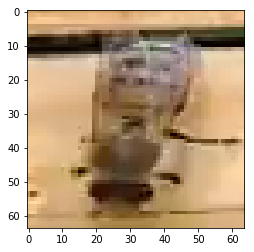

In [184]:
plt.imshow(vis_sample[0])

In [185]:
from keras import models
layer_outputs = [layer.output for layer in model2.layers[:12]] #top 10 layer, look at the summary above (top 10 lines) 
activation_model = models.Model(inputs=model2.input, outputs=layer_outputs)

In [186]:
layer_outputs

[<tf.Tensor 'conv2d_4/BiasAdd:0' shape=(?, 62, 62, 11) dtype=float32>,
 <tf.Tensor 'batch_normalization_4/cond/Merge:0' shape=(?, 62, 62, 11) dtype=float32>,
 <tf.Tensor 'activation_4/Relu:0' shape=(?, 62, 62, 11) dtype=float32>,
 <tf.Tensor 'max_pooling2d_4/MaxPool:0' shape=(?, 31, 31, 11) dtype=float32>,
 <tf.Tensor 'conv2d_5/Relu:0' shape=(?, 29, 29, 21) dtype=float32>,
 <tf.Tensor 'batch_normalization_5/cond/Merge:0' shape=(?, 29, 29, 21) dtype=float32>,
 <tf.Tensor 'activation_5/Relu:0' shape=(?, 29, 29, 21) dtype=float32>,
 <tf.Tensor 'max_pooling2d_5/MaxPool:0' shape=(?, 15, 15, 21) dtype=float32>,
 <tf.Tensor 'conv2d_6/Relu:0' shape=(?, 13, 13, 41) dtype=float32>,
 <tf.Tensor 'batch_normalization_6/cond/Merge:0' shape=(?, 13, 13, 41) dtype=float32>,
 <tf.Tensor 'activation_6/Relu:0' shape=(?, 13, 13, 41) dtype=float32>,
 <tf.Tensor 'max_pooling2d_6/MaxPool:0' shape=(?, 7, 7, 41) dtype=float32>]

In [187]:
activations = activation_model.predict(vis_sample)

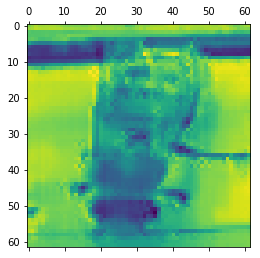

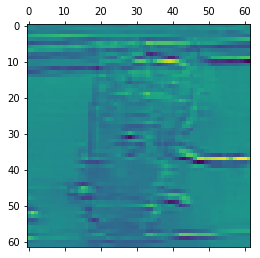

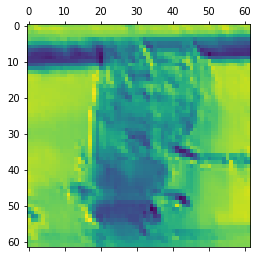

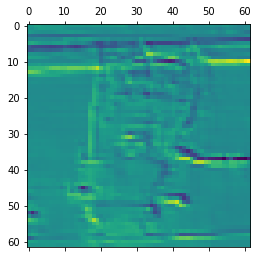

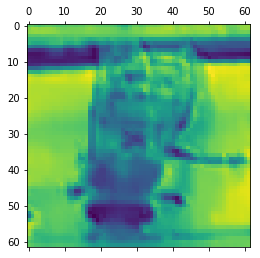

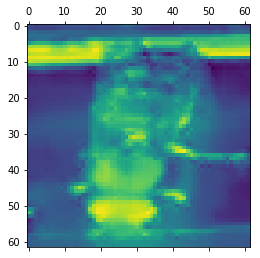

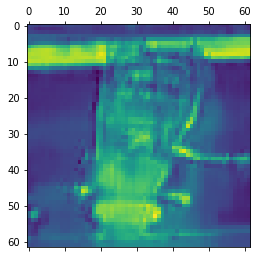

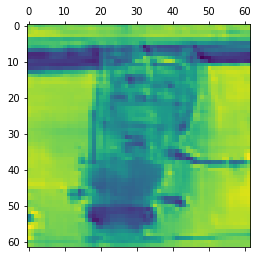

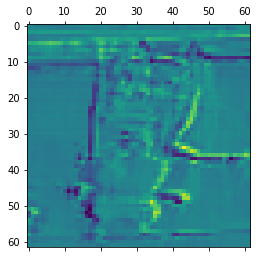

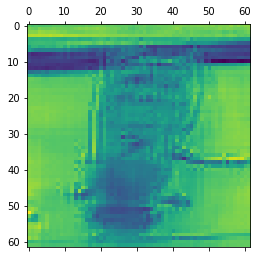

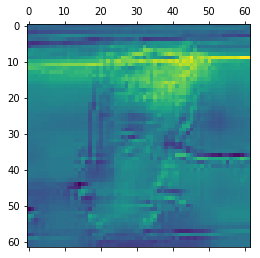

In [188]:
#first layer activation
first = activations[0]
#4th channel of the first layer on the ant-problem picture. There are 11 filters total in the first conv layer
for i in range(0,11):
    plt.matshow(first[0,:,:,i],cmap='viridis')

As expected, the first conv layer are mainly edge detectors, We have not lost any "generalization". As we move further and further down, we should see changes such that the later filters will be focused on "local" features: ie, stripes, head, wings, ect...

/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


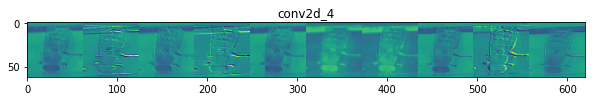

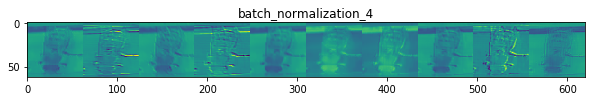

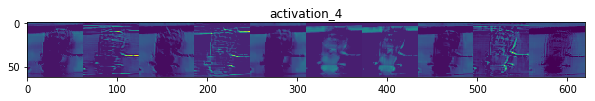

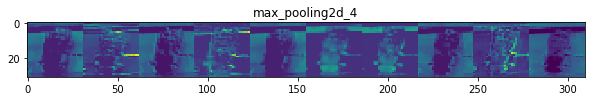

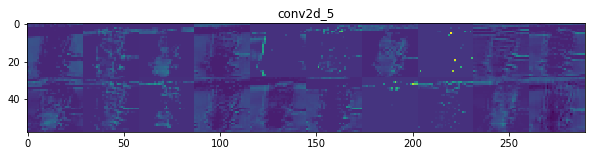

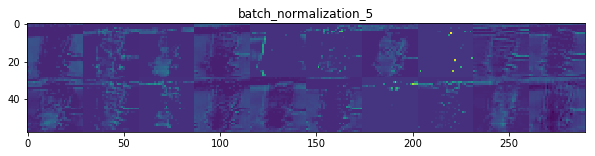

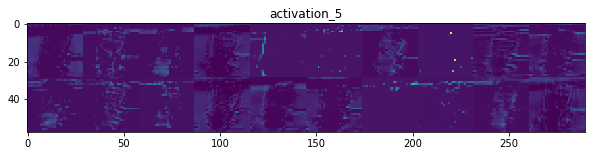

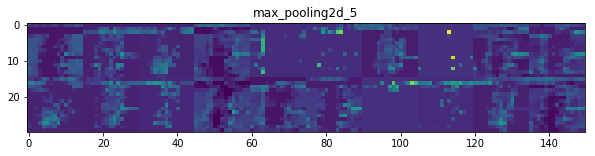

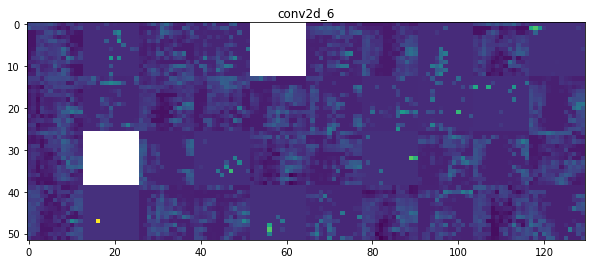

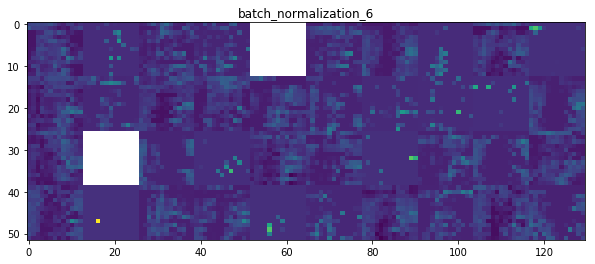

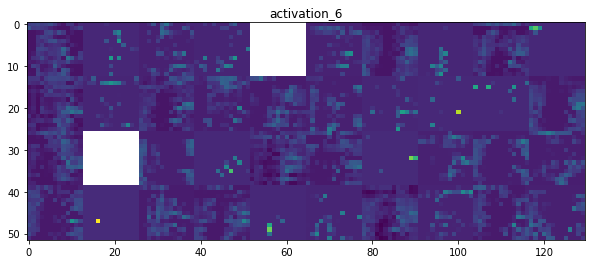

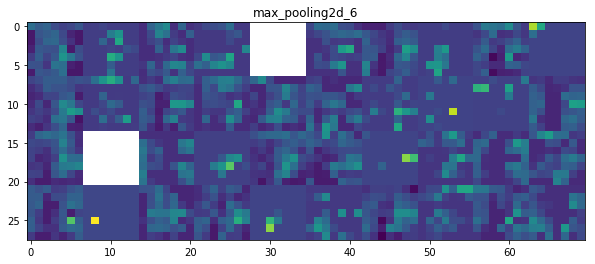

In [189]:
#visualizing every channel in all those conv layers
#helper function courtesy of Francois Challet in Deep Learning With Python book
%matplotlib inline
layer_names = []
for layer in model2.layers[:12]: #up to 11 layers stack
    layer_names.append(layer.name)
    #print(layer_names)
    
img_per_row = 10
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    
    n_cols = n_features//img_per_row
    display_grid = np.zeros((size*n_cols,img_per_row*size))
    
    for col in range(n_cols):
        for row in range(img_per_row):
            channel_img = layer_activation[0,:,:,col*img_per_row+row]
            channel_img -= channel_img.mean()
            channel_img /= channel_img.std()
            channel_img *64
            channel_img += 128
            #channel_img = np.clip(channel_img,0,255).astype("uint8")
            display_grid[col*size : (col + 1) * size, row*size : (row + 1)*size] = channel_img

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


So what's going on here?
It seems that the first layers of filters are generalized edge dectectors. As we move further down the chain, we are facing more and more abstractions, being encoded in localized areas of the bees. However, at a certain point, we see there are blank filters...that means these filters to detect the classification of bee labels didn't get activated. Hence, we have narrowed down our search by classification even further.

Summary:
1. don't over-use too many filters, as it will overfit our problem.
2. The number of filters should increase as we go deeper, while the img sizes should decrease.
3. Make sure we don't bottleneck/over-nodding the fully connected layers. A right # of nodes will help.
4. proportional sampling and image augmentation are great way to help our model to predict the problem.
5. Control the learning rate to smooth out our benchmark, with the expense of higher epoch count.
6. Oversampling to the max is not a good way to approach cnn problem for the most part.
7. Filter visualization to help visualize what features of our images are important in specifying a class/label type.

Other thoughts:
1. If we have more computing resources, and the problem is general enough, one can use pre-trained network to fine-tune/tweak. However, this problem is just mostly dealing with bees images so we can get away with that. There is also no classes outside of being "bees"